# Imports

In [1]:
import random
import json
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Player.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Street.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Utility.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Station.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Chance.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Tax.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Go.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Jail.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\FreeParking.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\GoToJail.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\CommunityChest.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\MonopolyBoard.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Strategy.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\RandomStrategy.py"

%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\MonopolyBoardMCTS.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\Node.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\MCTS.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\State.py"

random.seed(42)

# Game Rollouts - Random Strategy

In [2]:
def game():
    # create board and add players
    board = MonopolyBoardMCTS()
    agent = Player('Agent')
    player = Player('Player')
    board.add_agent(agent)
    board.add_other_player(player)

    # using a random strategy
    strategy = RandomStrategy()
    board.strategy = strategy

    # run MCTS game
    root_state = State()
    root_state.from_monopoly_board(board)
    mcts = MCTS(root_state, max_iterations=100, exploration_weight=2**0.5, max_simulations=50)
    mcts.run_game(max_actions=5000)

    return mcts.root.state.rounds, mcts.root.state.agent, mcts.root.state.other_players[0], \
        mcts.root.state.properties, mcts.root.state.stations, mcts.root.state.utilities

In [3]:
random.seed(42)
num_games = 100
game_outcomes = {'Rounds': [], 'Agent': [], 'Other player(s)': [], 'Properties': [], 'Stations': [], 'Utilities': []}

for _ in range(num_games):
    rounds, agent, other_players, properties, stations, utilities = game()
    game_outcomes['Rounds'].append(rounds)
    game_outcomes['Agent'].append(agent)
    game_outcomes['Other player(s)'].append(other_players)
    game_outcomes['Properties'].append(properties)
    game_outcomes['Stations'].append(stations)
    game_outcomes['Utilities'].append(utilities)

Running MCTS game:  41%|████      | 2058/5000 [07:36<10:52,  4.51it/s]  


In [6]:
file_path = 'MCTS_RandomStrategy_100_game_outcomes.json'
with open(file_path, 'w') as json_file:
    json.dump(game_outcomes, json_file, indent=4)

## Analysing Game Rollouts

In [25]:
file_path = 'MCTS_RandomStrategy_100_game_outcomes.json'
with open(file_path, 'r') as json_file:
    game_outcomes = json.load(json_file)

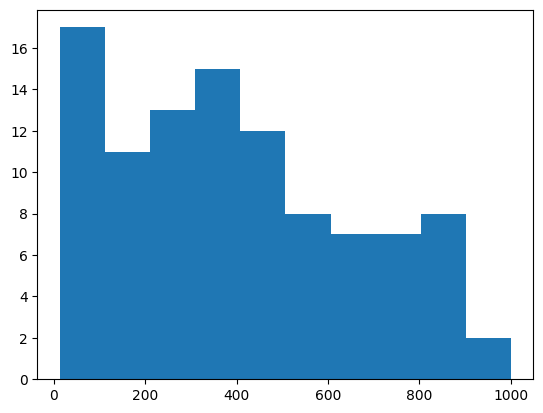

In [29]:
plt.hist(game_outcomes['Rounds'])
plt.show()

In [28]:
agent_losses = sum([agent[3] for agent in game_outcomes['Agent']])
agent_wins = sum([agent[3] for agent in game_outcomes['Other player(s)']])
game_not_ended = 100 - agent_losses - agent_wins

print(f'Out of 100 games with 2 players, run for 1000 decisions, using a random strategy, the agent won \n {agent_wins} games, the other player won {agent_losses} games. The other {game_not_ended} games did not end in this time period.')

Out of 100 games with 2 players, run for 1000 decisions, using a random strategy, the agent won 
 23 games, the other player won 3 games. The other 74 games did not end in this time period.


# Game Rollouts -  Base Strategy

In [2]:
def game():
    node_actions = []

    # create board and add players
    board = MonopolyBoardMCTS()
    agent = Player('Agent')
    player = Player('Player')
    board.add_agent(agent)
    board.add_other_player(player)
    
    # run MCTS game
    root_state = State()
    root_state.from_monopoly_board(board)
    mcts = MCTS(root_state, max_iterations=100, exploration_weight=2**0.5, max_simulations=50)
    
    actions = 0
    max_actions = 5000
    pbar = tqdm(total=max_actions, desc="Running MCTS game")

    # play game until a maximum number of actions or game has ended
    while actions < max_actions and not mcts.root.is_terminal():
        mcts.run()
        legal_actions = [child.action for child in mcts.root.parent.children]
        node_actions.append((mcts.root.action, legal_actions, mcts.root.state.rounds))
        actions += 1
        pbar.update(1)

    pbar.close()

    return mcts.root.state.rounds, mcts.root.state.agent, mcts.root.state.other_players[0], \
        mcts.root.state.properties, mcts.root.state.stations, mcts.root.state.utilities, node_actions

In [3]:
random.seed(42)
num_games = 100
node_actions_100 = []
game_outcomes = {'Rounds': [], 'Agent': [], 'Other player(s)': [], 'Properties': [], 'Stations': [], 'Utilities': []}

for _ in range(num_games):
    rounds, agent, other_players, properties, stations, utilities, node_actions = game()
    game_outcomes['Rounds'].append(rounds)
    game_outcomes['Agent'].append(agent)
    game_outcomes['Other player(s)'].append(other_players)
    game_outcomes['Properties'].append(properties)
    game_outcomes['Stations'].append(stations)
    game_outcomes['Utilities'].append(utilities)
    node_actions_100.append(node_actions)

Running MCTS game:  73%|███████▎  | 3641/5000 [17:33<09:52,  2.29it/s]  

In [ ]:
file_path = 'MCTS_BaseStrategy_100_game_outcomes.json'
with open(file_path, 'w') as json_file:
    json.dump(game_outcomes, json_file, indent=4)

In [ ]:
file_path = 'MCTS_BaseStrategy_100_node_actions.json'
with open(file_path, 'w') as json_file:
    json.dump(node_actions_100, json_file, indent=4)

## Analysing Game Outcomes

In [33]:
file_path = 'MCTS_BaseStrategy_100_game_outcomes.json'
with open(file_path, 'r') as json_file:
    game_outcomes = json.load(json_file)

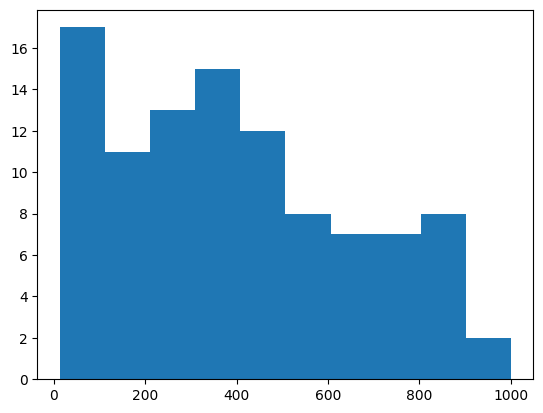

In [34]:
plt.hist(game_outcomes['Rounds'])
plt.show()

In [35]:
agent_losses = sum([agent[3] for agent in game_outcomes['Agent']])
agent_wins = sum([agent[3] for agent in game_outcomes['Other player(s)']])
game_not_ended = 100 - agent_losses - agent_wins

print(f'Out of 100 games with 2 players, run for 1000 decisions, using a base strategy, the agent won \n {agent_wins} games, the other player won {agent_losses} games. The other {game_not_ended} games did not end in this time period.')

Out of 100 games with 2 players, run for 1000 decisions, using a base strategy, the agent won 
 23 games, the other player won 3 games. The other 74 games did not end in this time period.


In [99]:
property_names = [
    "Old Kent Road",
    "Whitechapel Road",
    "The Angel Islington",
    "Euston Road",
    "Pentonville Road",
    "Pall Mall",
    "Whitehall",
    "Northumberland Avenue",
    "Bow Street",
    "Marlborough Street",
    "Vine Street",
    "Strand",
    "Fleet Street",
    "Trafalgar Square",
    "Leicester Square",
    "Coventry Street",
    "Piccadilly",
    "Regent Street",
    "Oxford Street",
    "Bond Street",
    "Park Lane",
    "Mayfair",
    "King's Cross Station",
    "Marylebone Station",
    "Fenchurch Street Station",
    "Liverpool Street Station",
    "Electric Company",
    "Water Works"
]


In [100]:
props_bought_player = [0]*28
props_bought_agent = [0]*28

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx] += 0.01
        elif prop[0] == 'Agent':
            props_bought_agent[idx] += 0.01
        else:
            pass

for game in game_outcomes['Stations']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx+22] += 0.01
        elif prop[0] == 'Agent':
            props_bought_agent[idx+22] += 0.01
        else:
            pass

for game in game_outcomes['Utilities']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx+26] += 0.01
        elif prop[0] == 'Agent':
            props_bought_agent[idx+26] += 0.01
        else:
            pass

In [160]:
def wilson_score_interval(p, n, z):
    z_squared = z**2
    phat = p + z_squared / (2 * n)
    margin_of_error = z * np.sqrt((p * (1 - p) / n) + z_squared / (4 * n))
    
    ci_lower = (phat - margin_of_error) / (1 + z_squared / n)
    ci_upper = (phat + margin_of_error) / (1 + z_squared / n)
    
    return ci_lower, ci_upper


In [316]:
def interval_property_plot(agent, player, ylabel, ylim0=0, ylim1=1):
    num_points = len(agent)
    ci_lower_props_bought_player = [0]*num_points
    ci_lower_props_bought_agent = [0]*num_points
    ci_upper_props_bought_player = [0]*num_points
    ci_upper_props_bought_agent = [0]*num_points

    z = norm.ppf(0.975)
    n = 100

    for idx, p in enumerate(player):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_player[idx] = ci_lower
        ci_upper_props_bought_player[idx] = ci_upper

    for idx, p in enumerate(agent):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_agent[idx] = ci_lower
        ci_upper_props_bought_agent[idx] = ci_upper

    x = range(num_points)
    plt.figure(figsize=(15, 8))

    vertical_lines = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5]
    for i in range(len(vertical_lines)):
        plt.axvline(vertical_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    if num_points > 22:
        vertical_lines = [21.5, 25.5]
        for i in range(len(vertical_lines)):
            plt.axvline(vertical_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    horizontal_lines = [0.2, 0.4, 0.6, 0.8]
    for i in range(len(horizontal_lines)):
        plt.axhline(horizontal_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    plt.fill_between(x, ci_lower_props_bought_player, ci_upper_props_bought_player, color='lightblue', alpha=0.5)
    plt.fill_between(x, ci_lower_props_bought_agent, ci_upper_props_bought_agent, color='pink', alpha=0.5)
    plt.scatter(x, player, alpha = 0.5, color = 'blue', label = 'Player')
    plt.scatter(x, agent, alpha = 0.5, color = 'red', label = 'Agent')
        
    plt.xticks(x, property_names[:num_points], rotation = 90)
    plt.xlabel('Property')
    plt.ylabel(ylabel)
    
    plt.ylim(ylim0, ylim1)
    plt.legend()
    plt.show()

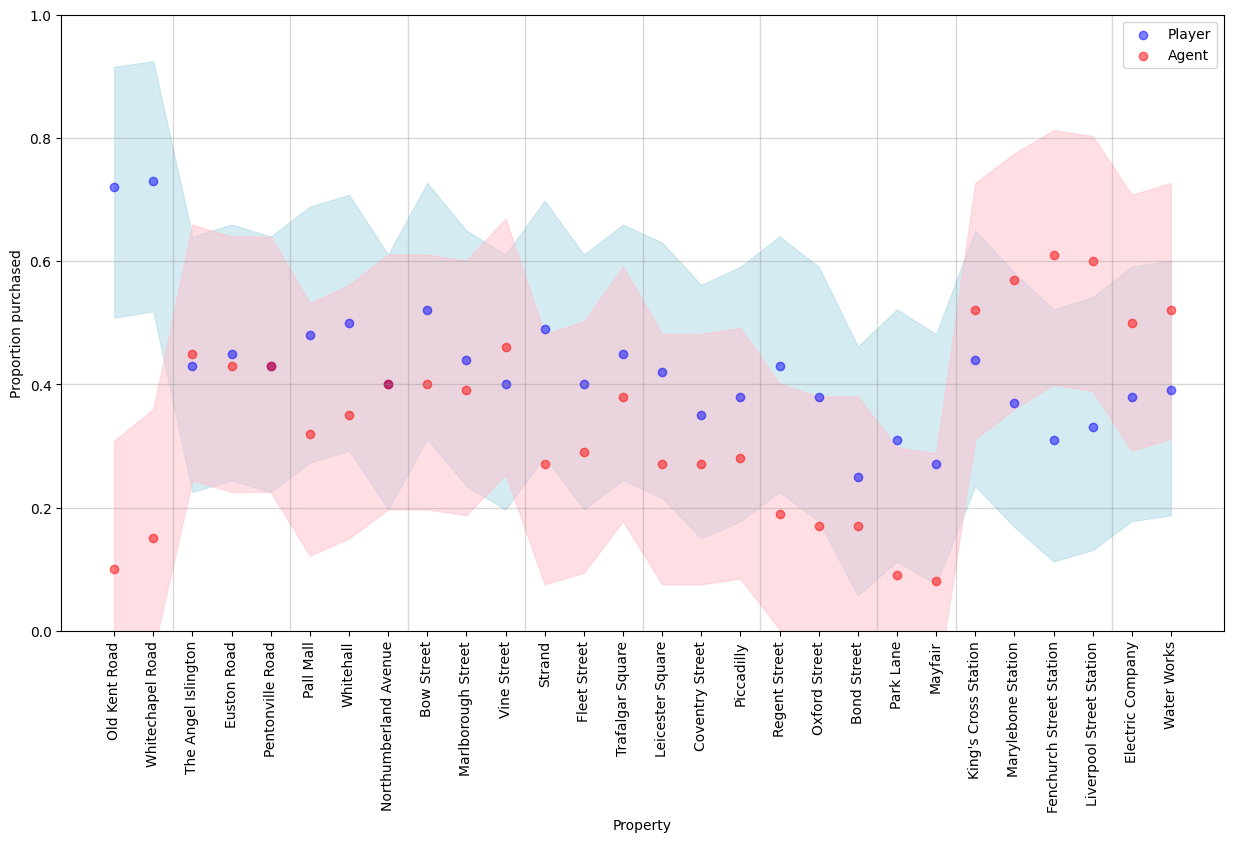

In [317]:
interval_property_plot(props_bought_player, props_bought_agent, 'Proportion purchased')

In [276]:
def interval_whiskers_property_plot(agent, player):
    ci_lower_props_bought_player = [0]*28
    ci_lower_props_bought_agent = [0]*28
    ci_upper_props_bought_player = [0]*28
    ci_upper_props_bought_agent = [0]*28

    z = norm.ppf(0.975)
    n = 100

    for idx, p in enumerate(player):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_player[idx] = p - ci_lower
        ci_upper_props_bought_player[idx] = ci_upper - p

    for idx, p in enumerate(agent):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_agent[idx] = p - ci_lower
        ci_upper_props_bought_agent[idx] = ci_upper - p

    x = range(28)
    plt.figure(figsize=(15, 8))

    vertical_lines = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 21.5, 25.5]
    for i in range(9):
        plt.axvline(vertical_lines[i], alpha = 0.5, color = 'gray', linewidth = 1)

    horizontal_lines = [0.2, 0.4, 0.6, 0.8]
    for i in range(len(horizontal_lines)):
        plt.axhline(horizontal_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    plt.errorbar(x, props_bought_player, yerr=[ci_lower_props_bought_player, ci_upper_props_bought_player], alpha = 0.5, fmt='o', color='blue', capsize=5, label='Player')
    plt.errorbar(x, props_bought_agent, yerr=[ci_lower_props_bought_agent, ci_upper_props_bought_agent], alpha = 0.5, fmt='o', color='red', capsize=5, label='Agent')
        
    plt.xticks(x, property_names, rotation = 90)
    plt.ylim(0, 1)
    plt.xlabel('Property')
    plt.ylabel('Proportion Purchased')
    plt.gca().xaxis.grid(False)
    plt.legend()
    plt.show()

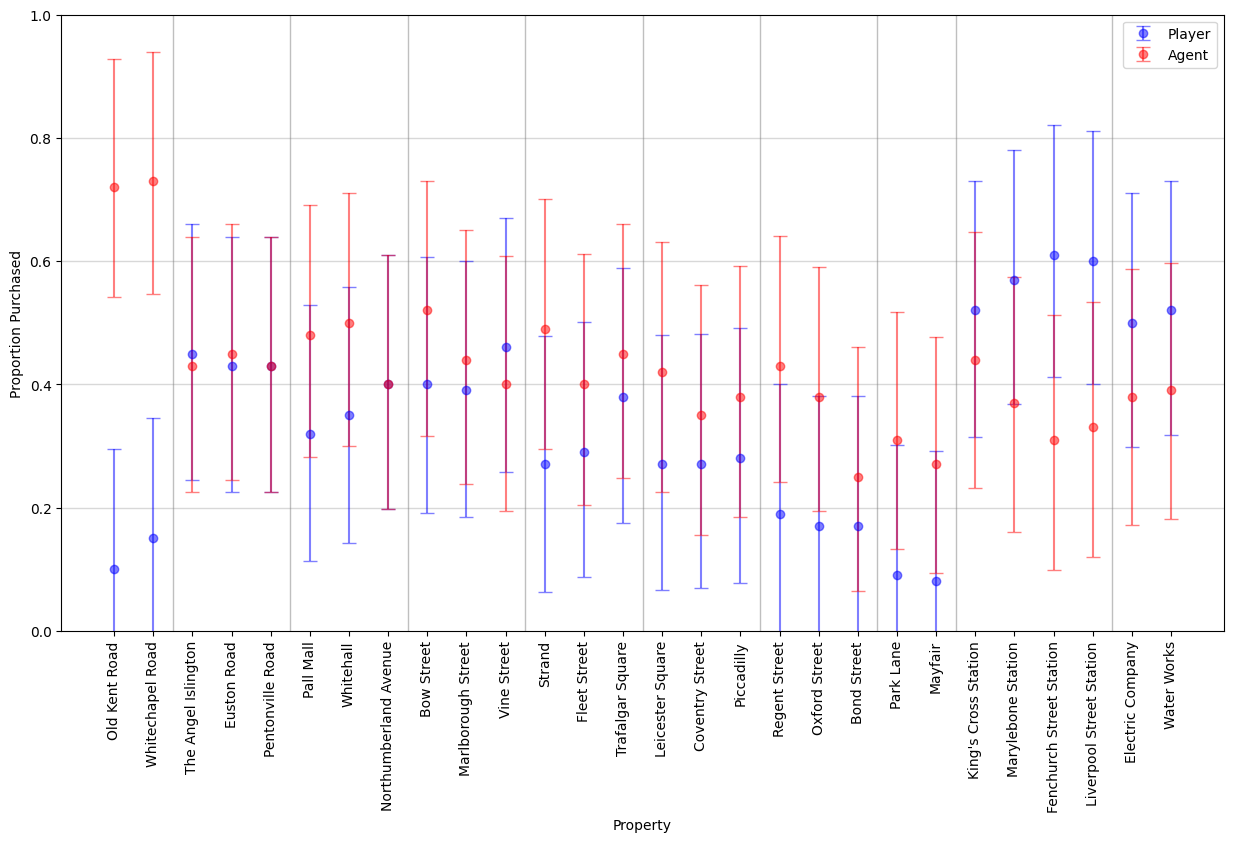

In [277]:
interval_whiskers_property_plot(props_bought_player, props_bought_agent)

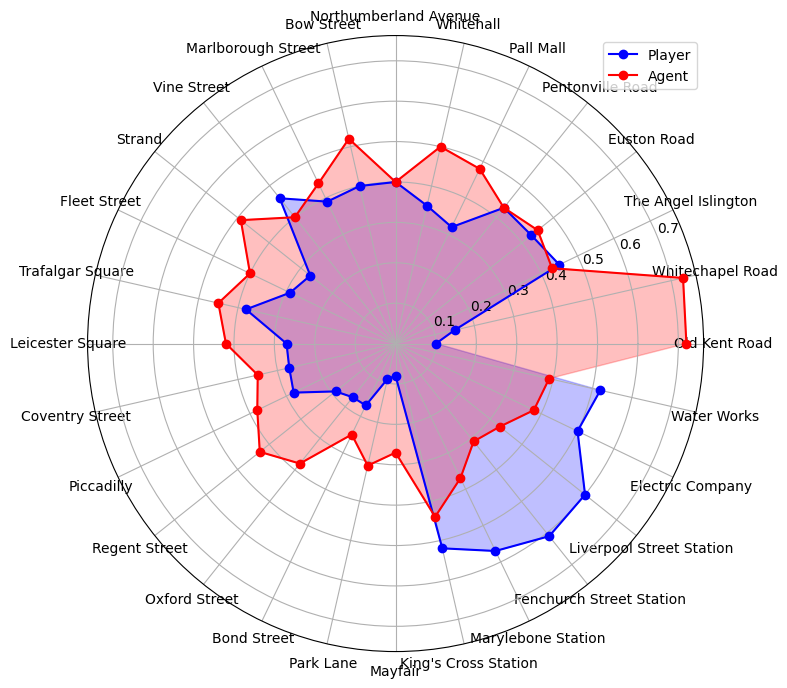

In [165]:
theta = np.linspace(0, 2 * np.pi, len(props_bought_player), endpoint=False)

plt.figure(figsize=(8, 8))
plt.subplot(111, polar=True)

plt.plot(theta, props_bought_player, 'o-', color='blue', label='Player')
plt.plot(theta, props_bought_agent, 'o-', color='red', label='Agent')
plt.fill(theta, props_bought_player, color='blue', alpha=0.25)
plt.fill(theta, props_bought_agent, color='red', alpha=0.25)
plt.thetagrids(np.arange(0, 360, 360 / len(property_names)), labels=property_names)
plt.legend()
plt.show()

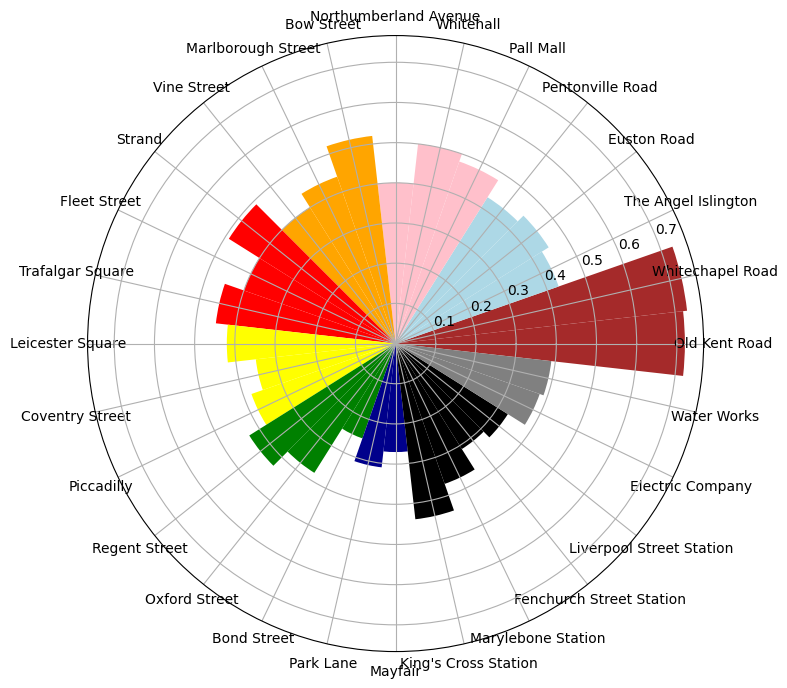

In [168]:
bar_colours = ['brown', 'brown', 'lightblue', 'lightblue', 'lightblue', 'pink', 'pink', 'pink',
               'orange', 'orange', 'orange', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 
               'green', 'green', 'green', 'darkblue', 'darkblue', 'black', 'black', 'black',
               'black', 'grey', 'grey']

theta = np.linspace(0, 2 * np.pi, len(props_bought_agent), endpoint=False)

plt.figure(figsize=(8, 8))
plt.subplot(111, polar=True)

width = 2 * np.pi / len(props_bought_agent)

for i in range(len(props_bought_agent)):
    plt.bar(theta[i], props_bought_agent[i], width=width, color=bar_colours[i])

plt.thetagrids(np.arange(0, 360, 360 / len(property_names)), labels=property_names)
plt.show()

In [173]:
num_props_bought_agent = [0] * 100
num_props_bought_player = [0] * 100

for idx, game in enumerate(game_outcomes['Properties']):
    for prop in game:
        if prop[0] == 'Agent':
            num_props_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_props_bought_player[idx] += 1
        else:
            pass

In [230]:
np.mean(num_props_bought_agent)

9.63

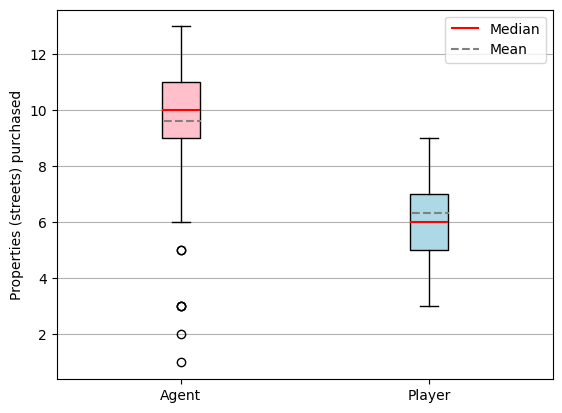

In [249]:
fig, ax = plt.subplots()
box = ax.boxplot([num_props_bought_agent, num_props_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=1.5, label='Median')
box['medians'][1].set(color='red', linewidth=1.5)

ax.set_xticks([1, 2])
ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_props_bought_agent), np.mean(num_props_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_props_bought_player), np.mean(num_props_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Properties (streets) purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [211]:
num_stations_bought_agent = [0] * 100
num_stations_bought_player = [0] * 100

for idx, game in enumerate(game_outcomes['Stations']):
    for prop in game:
        if prop[0] == 'Agent':
            num_stations_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_stations_bought_player[idx] += 1
        else:
            pass

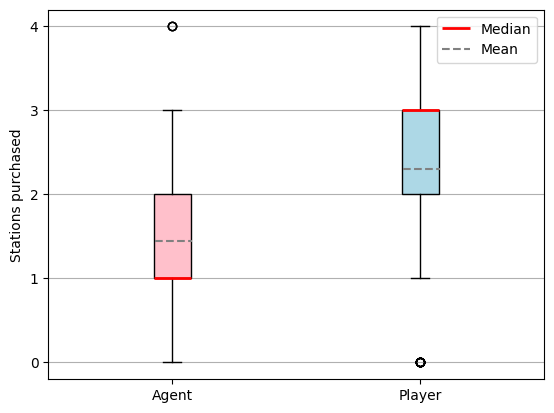

In [250]:
fig, ax = plt.subplots()
box = ax.boxplot([num_stations_bought_agent, num_stations_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=2, label='Median')
box['medians'][1].set(color='red', linewidth=2)

ax.set_xticks([1, 2])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_stations_bought_agent), np.mean(num_stations_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_stations_bought_player), np.mean(num_stations_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Stations purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [221]:
num_utilities_bought_agent = [0] * 100
num_utilities_bought_player = [0] * 100

for idx, game in enumerate(game_outcomes['Utilities']):
    for prop in game:
        if prop[0] == 'Agent':
            num_utilities_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_utilities_bought_player[idx] += 1
        else:
            pass

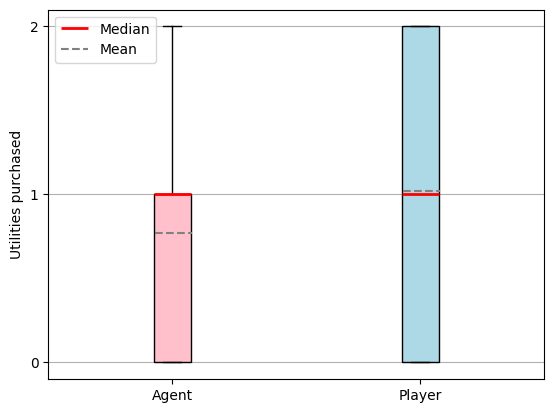

In [252]:
fig, ax = plt.subplots()
box = ax.boxplot([num_utilities_bought_agent, num_utilities_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=2, label='Median')
box['medians'][1].set(color='red', linewidth=2)

ax.set_xticks([1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_utilities_bought_agent), np.mean(num_utilities_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_utilities_bought_player), np.mean(num_utilities_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Utilities purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [313]:
houses_bought_player_1 = [0]*22
houses_bought_agent_1 = [0]*22
houses_bought_player_2 = [0]*22
houses_bought_agent_2 = [0]*22
houses_bought_player_3 = [0]*22
houses_bought_agent_3 = [0]*22
houses_bought_player_4 = [0]*22
houses_bought_agent_4 = [0]*22
hotels_bought_player = [0]*22
hotels_bought_agent = [0]*22
built_player = [0]*22
built_agent = [0]*22

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            if prop[1] > 0 or prop[2]:
                built_player[idx] += 0.01

            if prop[1] == 1:
                houses_bought_player_1[idx] += 0.01
            elif prop[1] == 2:
                houses_bought_player_2[idx] += 0.01
            elif prop[1] == 3:
                houses_bought_player_3[idx] += 0.01
            elif prop[1] == 4:
                houses_bought_player_4[idx] += 0.01
            elif prop[2]:
                hotels_bought_player[idx] += 0.01
            else:
                pass
        elif prop[0] == 'Agent':
            if prop[1] > 0 or prop[2]:
                built_agent[idx] += 0.01

            if prop[1] == 1:
                houses_bought_agent_1[idx] += 0.01
            elif prop[1] == 2:
                houses_bought_agent_2[idx] += 0.01
            elif prop[1] == 3:
                houses_bought_agent_3[idx] += 0.01
            elif prop[1] == 4:
                houses_bought_agent_4[idx] += 0.01
            elif prop[2]:
                hotels_bought_agent[idx] += 0.01
            else:
                pass
        else:
            pass

In [314]:
houses_bought_player_1_normalised = [houses_bought_player_1[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_1_normalised = [houses_bought_agent_1[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_2_normalised = [houses_bought_player_2[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_2_normalised = [houses_bought_agent_2[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_3_normalised = [houses_bought_player_3[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_3_normalised = [houses_bought_agent_3[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_4_normalised = [houses_bought_player_4[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_4_normalised = [houses_bought_agent_4[i]/props_bought_agent[i] for i in range(22)]
hotels_bought_player_normalised = [hotels_bought_player[i]/props_bought_player[i] for i in range(22)]
hotels_bought_agent_normalised = [hotels_bought_agent[i]/props_bought_agent[i] for i in range(22)]
built_player_normalised = [built_player[i]/props_bought_agent[i] for i in range(22)]
built_agent_normalised = [built_agent[i]/props_bought_agent[i] for i in range(22)]

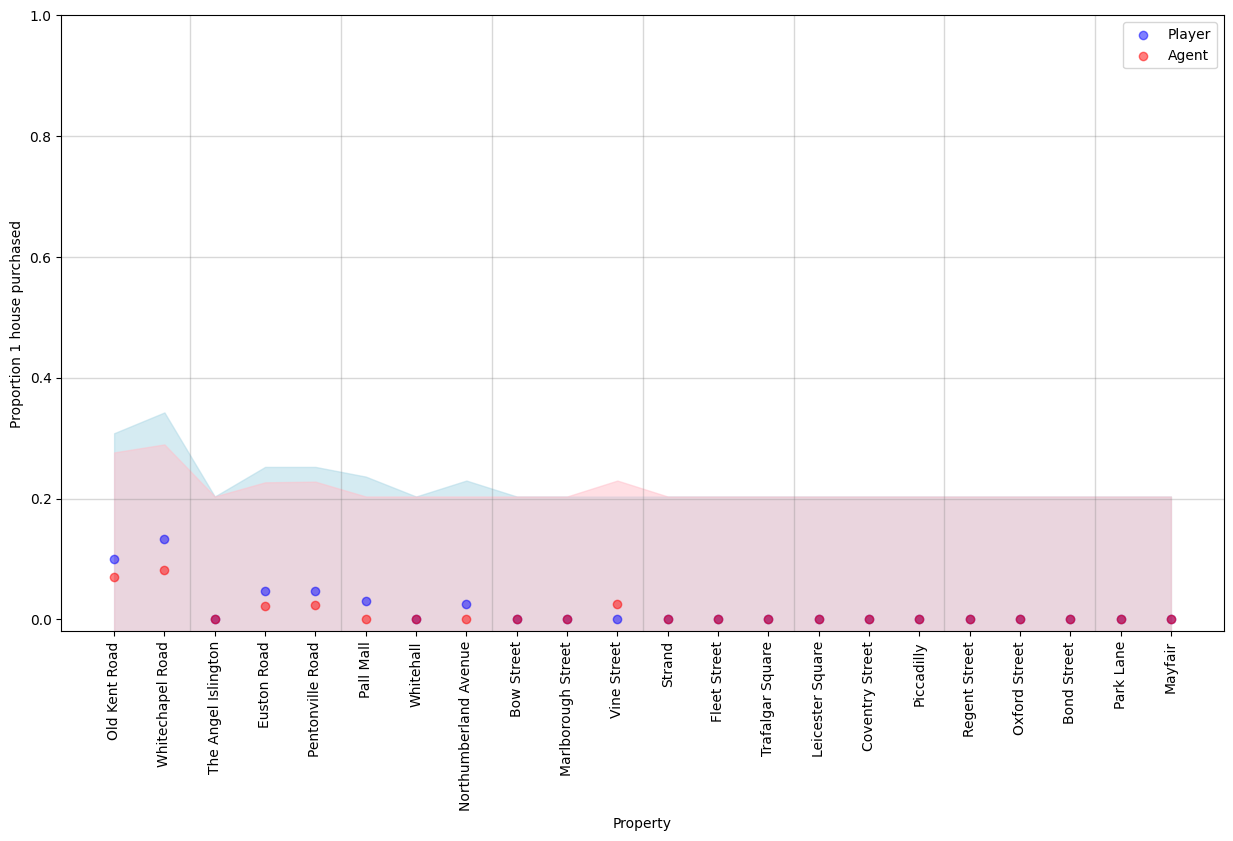

In [318]:
interval_property_plot(houses_bought_agent_1_normalised, houses_bought_player_1_normalised, 'Proportion 1 house purchased', -0.02, 1)

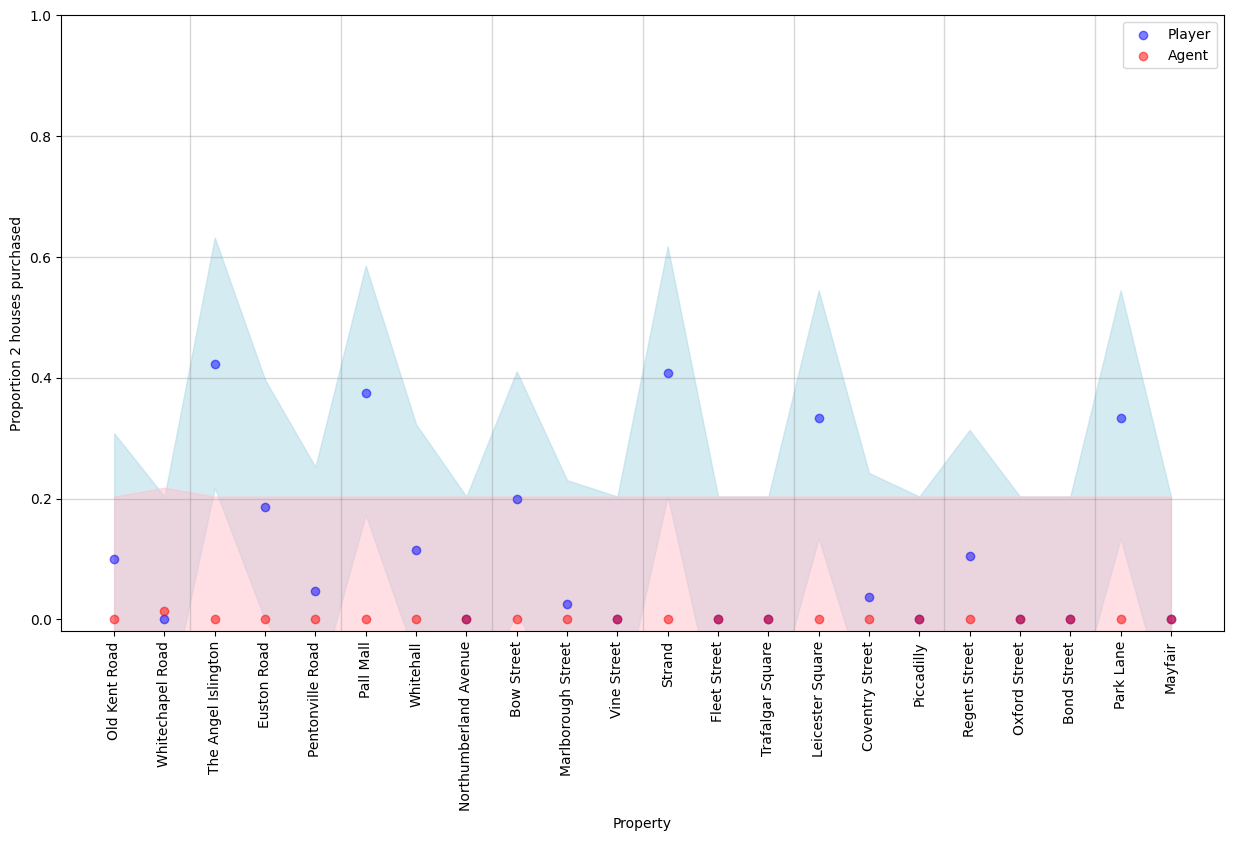

In [319]:
interval_property_plot(houses_bought_agent_2_normalised, houses_bought_player_2_normalised, 'Proportion 2 houses purchased', -0.02, 1)

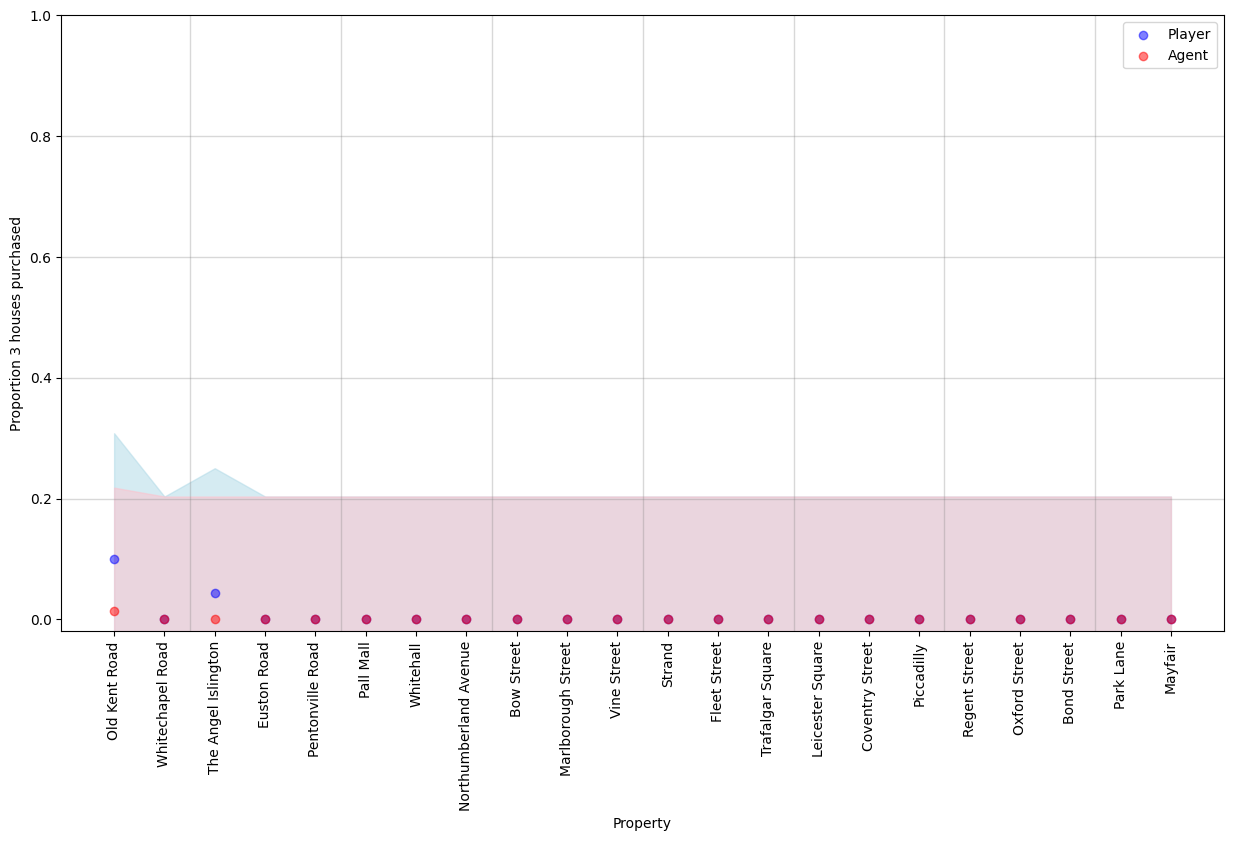

In [320]:
interval_property_plot(houses_bought_agent_3_normalised, houses_bought_player_3_normalised, 'Proportion 3 houses purchased', -0.02, 1)

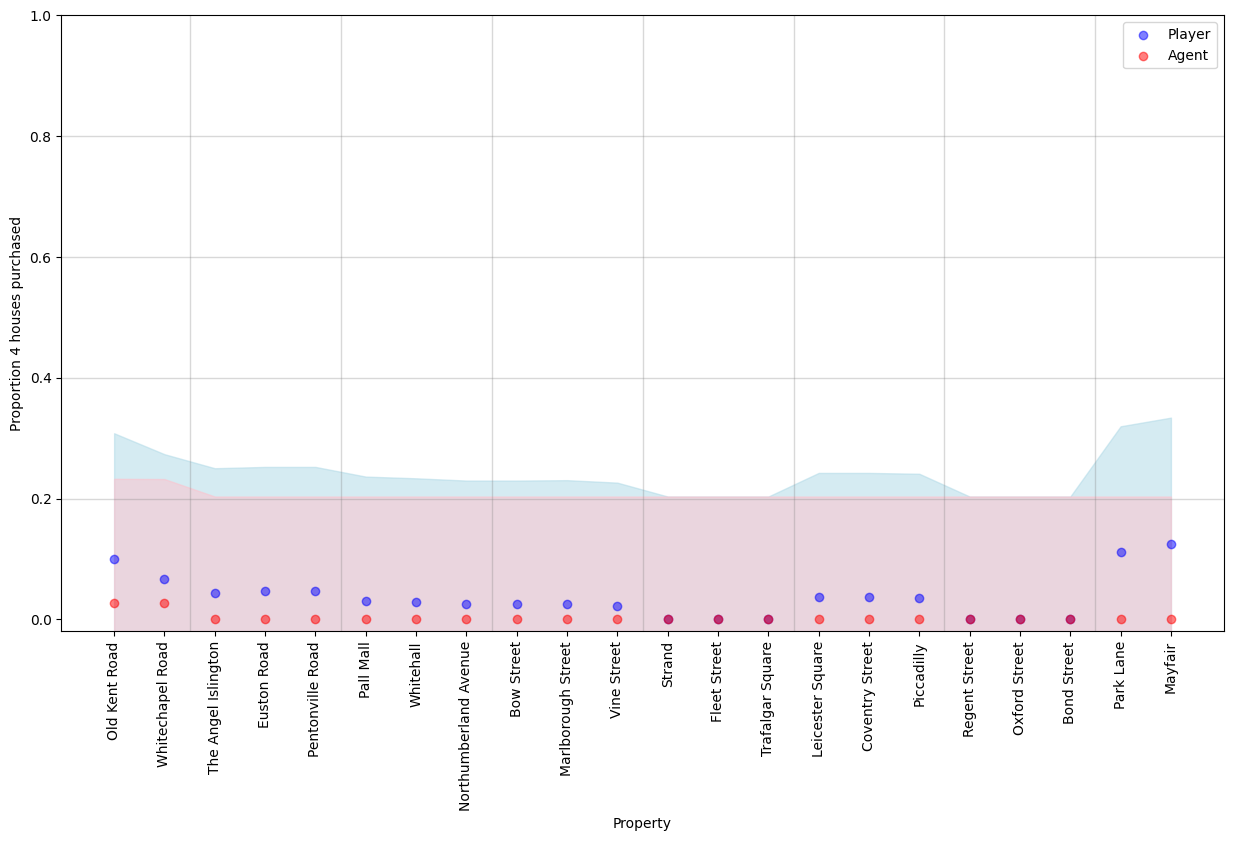

In [321]:
interval_property_plot(houses_bought_agent_4_normalised, houses_bought_player_4_normalised, 'Proportion 4 houses purchased', -0.02, 1)

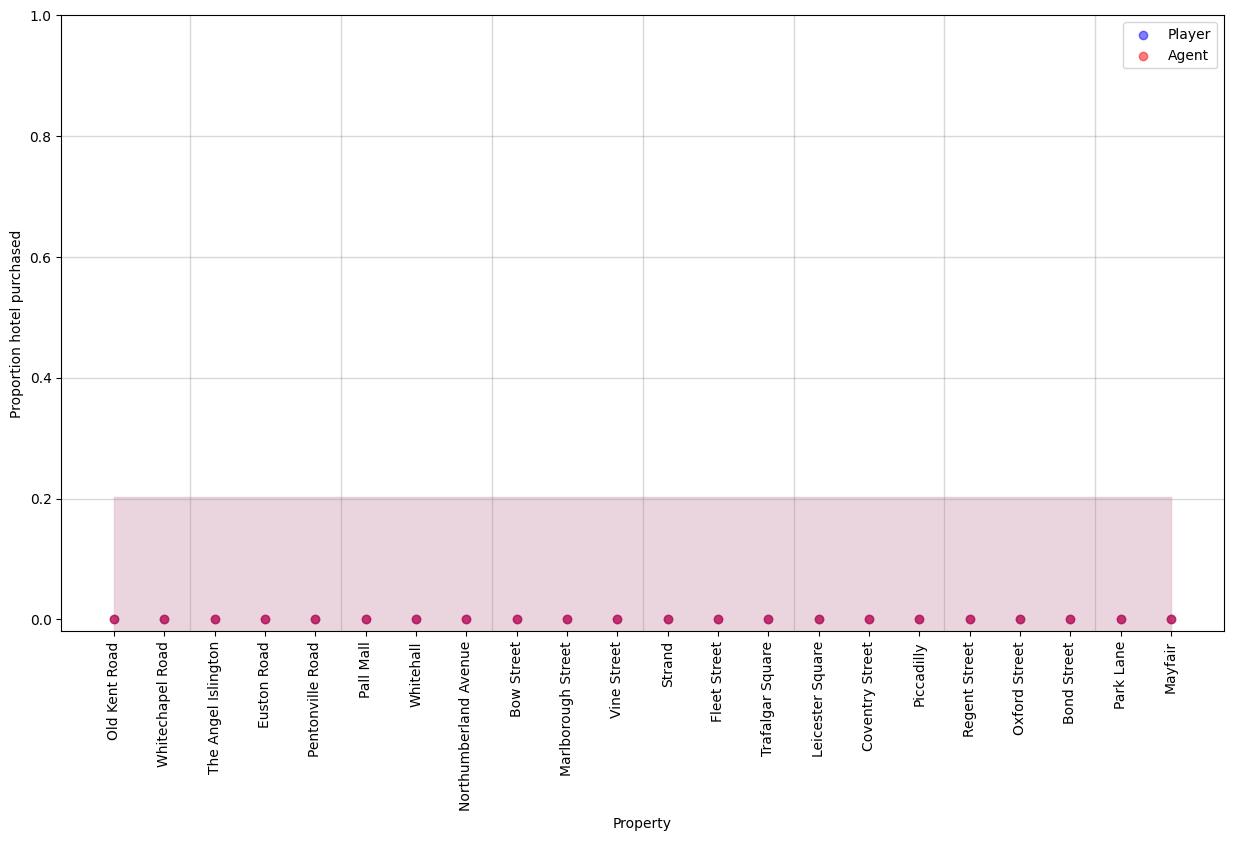

In [322]:
interval_property_plot(hotels_bought_agent_normalised, hotels_bought_player_normalised, 'Proportion hotel purchased', -0.02, 1)

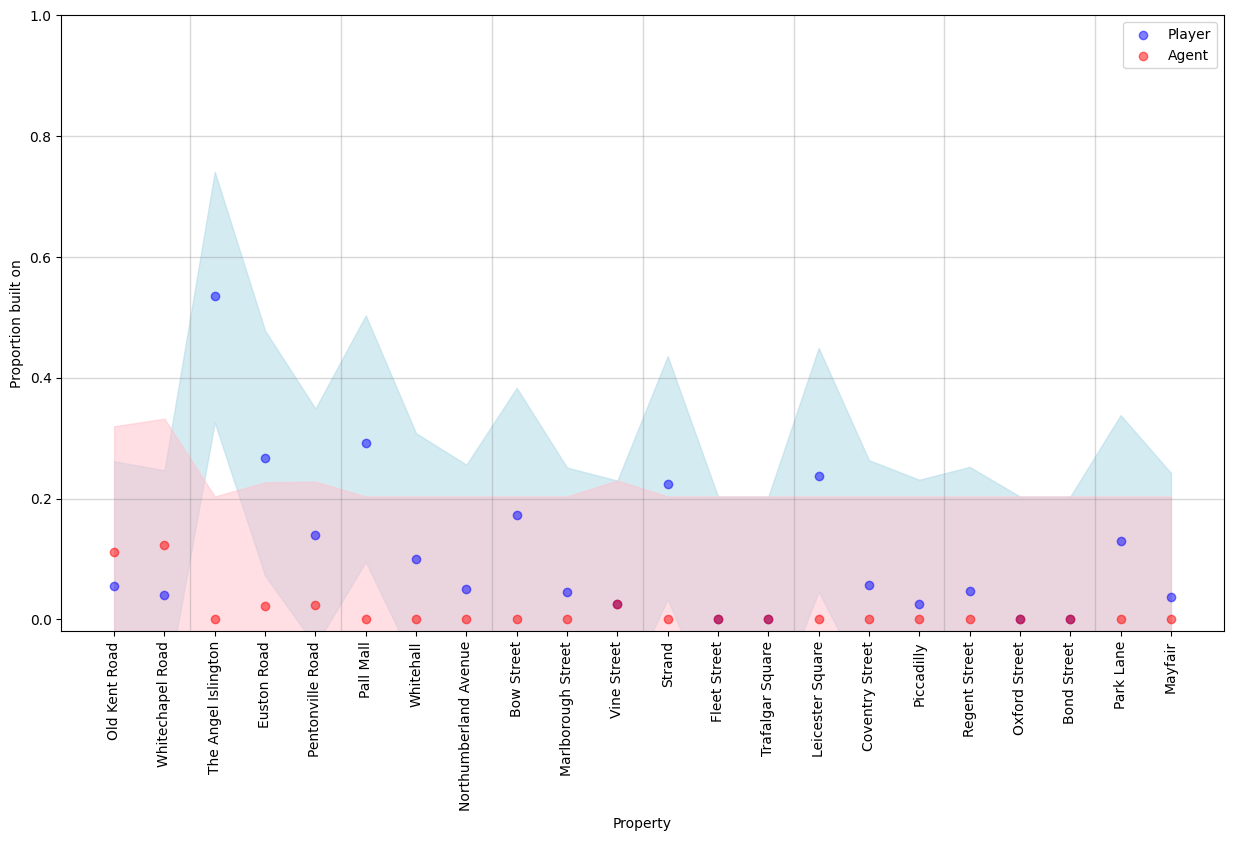

In [323]:
interval_property_plot(built_agent_normalised, built_player_normalised, 'Proportion built on', -0.02, 1)

In [326]:
mortgaged_player = [0]*28
mortgaged_agent = [0]*28

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[3]:
            mortgaged_player[idx] += 0.01
        elif prop[0] == 'Agent' and prop[3]:
            mortgaged_agent[idx] += 0.01
        else:
            pass

for game in game_outcomes['Stations']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[1]:
            mortgaged_player[idx+22] += 0.01
        elif prop[0] == 'Agent' and prop[1]:
            mortgaged_agent[idx+22] += 0.01
        else:
            pass

for game in game_outcomes['Utilities']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[1]:
            mortgaged_player[idx+26] += 0.01
        elif prop[0] == 'Agent' and prop[1]:
            mortgaged_agent[idx+26] += 0.01
        else:
            pass

In [327]:
mortgaged_player_normalised = [mortgaged_player[i]/props_bought_agent[i] for i in range(28)]
mortgaged_agent_normalised = [mortgaged_agent[i]/props_bought_agent[i] for i in range(28)]

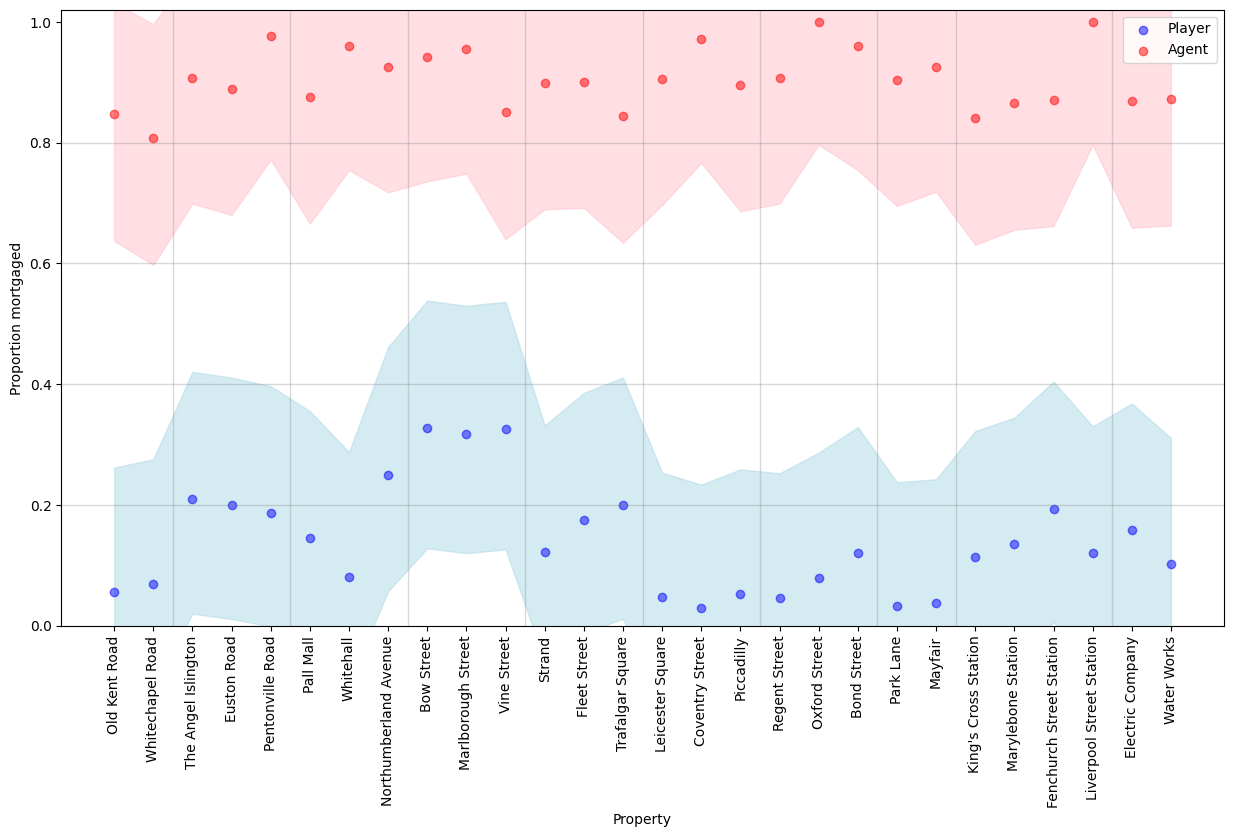

In [329]:
interval_property_plot(mortgaged_agent_normalised, mortgaged_player_normalised, 'Proportion mortgaged', 0, 1.02)

## Analysing Node Actions

In [ ]:
file_path = 'MCTS_BaseStrategy_100_node_actions.json'
with open(file_path, 'r') as json_file:
    node_actions_100 = json.load(json_file)

### Purchasing Properties

#### Should you purchase property x?

In [ ]:
property_names = [
    "Old Kent Road",
    "Whitechapel Road",
    "The Angel Islington",
    "Euston Road",
    "Pentonville Road",
    "Pall Mall",
    "Whitehall",
    "Northumberland Avenue",
    "Bow Street",
    "Marlborough Street",
    "Vine Street",
    "Strand",
    "Fleet Street",
    "Trafalgar Square",
    "Leicester Square",
    "Coventry Street",
    "Piccadilly",
    "Regent Street",
    "Oxford Street",
    "Bond Street",
    "Park Lane",
    "Mayfair",
    "King's Cross Station",
    "Marylebone Station",
    "Fenchurch Street Station",
    "Liverpool Street Station",
    "Electric Company",
    "Water Works"
]

In [ ]:
n = len(property_names)
df_purchase = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [ ]:
def populate_df(df, action_prefix):
    for node_actions_game in node_actions:
        max_round = node_actions_game[-1][-1]
        for action, legal_actions, round in node_actions_game:
            purchase_actions = [legal_action for legal_action in legal_actions if legal_action.startswith("Purchase")]

            if round < max_round//2:
                if action.startswith(action_prefix):
                    property_name = action[len(action_prefix):].strip()
                    df.loc[df["Property"] == property_name, "Action taken (early game)"] += 1

                if purchase_actions:
                    for purchase_action in purchase_actions:
                        property_name = purchase_action[len(action_prefix):].strip()
                        df.loc[df["Property"] == property_name, "In legal actions (early game)"] += 1

            else:
                if action.startswith(action_prefix):
                    property_name = action[len(action_prefix):].strip()
                    df.loc[df["Property"] == property_name, "Action taken (late game)"] += 1

                if purchase_actions:
                    for purchase_action in purchase_actions:
                        property_name = purchase_action[len(action_prefix):].strip()
                        df.loc[df["Property"] == property_name, "In legal actions (late game)"] += 1

In [ ]:
def wilson_score_error(p, n, z=norm.ppf(0.975)):
    z_squared = z**2
    phat = p + z_squared / (2 * n)
    margin_of_error = z * np.sqrt((p * (1 - p) / n) + z_squared / (4 * n))
    error = p - ((phat - margin_of_error) / (1 + z_squared / n))
    return error

In [ ]:
populate_df(df_purchase, "Purchase")

In [ ]:
df_purchase['Proportion purchased (early game)'] = df_purchase['Action taken (early game)']/df_purchase['In legal actions (early game)']
df_purchase['Proportion purchased (late game)'] = df_purchase['Action taken (late game)']/df_purchase['In legal actions (late game)']
df_purchase['Error (early game)'] = wilson_score_error(df_purchase['Proportion purchased (early game)'], df_purchase['In legal actions (early game)'])
df_purchase['Error (late game)'] = wilson_score_error(df_purchase['Proportion purchased (early game)'], df_purchase['In legal actions (late game)'])
df_purchase.head()

In [ ]:
fig = px.scatter(
    df_purchase,
    x='Property',
    y='Proportion purchased (early game)',
    labels={'y': 'Proportion purchased'},
    color='blue',
    error_y='Error (early game)',
    name='Early game progression' 
)

fig2 = px.scatter(
    df_purchase,
    x='Property',
    y='Proportion purchased (late game)',
    labels={'y': 'Proportion purchased'},
    color='red',
    error_y='Error (late game)',
    name='Late game progression' 
)

fig.add_trace(fig2.data[0])
fig.show()

### Building on Properties

#### Should I purchase a house on property x?

In [ ]:
n = len(property_names)
df_build_house = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [ ]:
populate_df(df_build_house, "Buy house on")

In [ ]:
df_build_house['Proportion built house on (early game)'] = df_build_house['Action taken (early game)']/df_build_house['In legal actions (early game)']
df_build_house['Proportion built house on (late game)'] = df_build_house['Action taken (late game)']/df_build_house['In legal actions (late game)']
df_build_house['Error (early game)'] = wilson_score_error(df_build_house['Proportion built house on (early game)'], df_build_house['In legal actions (early game)'])
df_build_house['Error (late game)'] = wilson_score_error(df_build_house['Proportion built house on (early game)'], df_build_house['In legal actions (late game)'])
df_build_house.head()

In [ ]:
fig = px.scatter(
    df_build_house,
    x='Property',
    y='Proportion built house on (early game)',
    labels={'y': 'Proportion built house on'},
    color='blue',
    error_y='Error (early game)',
    name='Early game progression' 
)

fig2 = px.scatter(
    df_build_house,
    x='Property',
    y='Proportion built house on (late game)',
    labels={'y': 'Proportion built house on'},
    color='red',
    error_y='Error (late game)',
    name='Late game progression' 
)

fig.add_trace(fig2.data[0])
fig.show()

#### A hotel?

In [ ]:
n = len(property_names)
df_build_hotel = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [ ]:
populate_df(df_build_hotel, "Buy hotel on")

In [ ]:
df_build_hotel['Proportion built hotel on (early game)'] = df_build_hotel['Action taken (early game)']/df_build_hotel['In legal actions (early game)']
df_build_hotel['Proportion built hotel on (late game)'] = df_build_hotel['Action taken (late game)']/df_build_hotel['In legal actions (late game)']
df_build_hotel['Error (early game)'] = wilson_score_error(df_build_hotel['Proportion built hotel on (early game)'], df_build_hotel['In legal actions (early game)'])
df_build_hotel['Error (late game)'] = wilson_score_error(df_build_hotel['Proportion built hotel on (early game)'], df_build_hotel['In legal actions (late game)'])
df_build_hotel.head()

In [ ]:
fig = px.scatter(
    df_build_hotel,
    x='Property',
    y='Proportion built hotel on (early game)',
    labels={'y': 'Proportion built hotel on'},
    color='blue',
    error_y='Error (early game)',
    name='Early game progression' 
)

fig2 = px.scatter(
    df_build_hotel,
    x='Property',
    y='Proportion built hotel on (late game)',
    labels={'y': 'Proportion built hotel on'},
    color='red',
    error_y='Error (late game)',
    name='Late game progression' 
)

fig.add_trace(fig2.data[0])
fig.show()

#### Should I build on property x?

In [ ]:
df_build = pd.DataFrame({'Property': property_names, 
                         'In legal actions (early game)': df_build_house['In legal actions (early game)']+df_build_hotel['In legal actions (early game)'], 
                         'In legal actions (late game)': df_build_house['In legal actions (late game)']+df_build_hotel['In legal actions (late game)'],
                         'Action taken (early game)': df_build_house['Action taken (early game)']+df_build_hotel['Action taken (early game)'], 
                         'Action taken (late game)': df_build_house['Action taken (late game)']+df_build_hotel['Action taken (late game)']})

In [ ]:
df_build['Proportion built on (early game)'] = df_build['Action taken (early game)']/df_build['In legal actions (early game)']
df_build['Proportion built on (late game)'] = df_build['Action taken (late game)']/df_build['In legal actions (late game)']
df_build['Error (early game)'] = wilson_score_error(df_build['Proportion built on (early game)'], df_build['In legal actions (early game)'])
df_build['Error (late game)'] = wilson_score_error(df_build['Proportion built on (early game)'], df_build['In legal actions (late game)'])
df_build.head()

In [ ]:
fig = px.scatter(
    df_build,
    x='Property',
    y='Proportion built on (early game)',
    labels={'y': 'Proportion built on'},
    color='blue',
    error_y='Error (early game)',
    name='Early game progression' 
)

fig2 = px.scatter(
    df_build,
    x='Property',
    y='Proportion built on (late game)',
    labels={'y': 'Proportion built on'},
    color='red',
    error_y='Error (late game)',
    name='Late game progression' 
)

fig.add_trace(fig2.data[0])
fig.show()

### Mortgaging Properties

#### Should I mortgage property x?

In [ ]:
n = len(property_names)
df_mortgage = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [ ]:
populate_df(df_mortgage, "Mortgage")

In [ ]:
df_mortgage['Proportion mortgaged (early game)'] = df_mortgage['Action taken (early game)']/df_mortgage['In legal actions (early game)']
df_mortgage['Proportion mortgaged (late game)'] = df_mortgage['Action taken (late game)']/df_mortgage['In legal actions (late game)']
df_mortgage['Error (early game)'] = wilson_score_error(df_mortgage['Proportion mortgaged (early game)'], df_mortgage['In legal actions (early game)'])
df_mortgage['Error (late game)'] = wilson_score_error(df_mortgage['Proportion mortgaged (early game)'], df_mortgage['In legal actions (late game)'])
df_mortgage.head()

In [ ]:
fig = px.scatter(
    df_mortgage,
    x='Property',
    y='Proportion mortgaged (early game)',
    labels={'y': 'Proportion mortgaged'},
    color='blue',
    error_y='Error (early game)',
    name='Early game progression' 
)

fig2 = px.scatter(
    df_mortgage,
    x='Property',
    y='Proportion mortgaged (late game)',
    labels={'y': 'Proportion mortgaged'},
    color='red',
    error_y='Error (late game)',
    name='Late game progression' 
)

fig.add_trace(fig2.data[0])
fig.show()

#### Should I unmortgage property x?

In [ ]:
n = len(property_names)
df_unmortgage = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [ ]:
populate_df(df_unmortgage, "Mortgage")

In [ ]:
df_unmortgage['Proportion unmortgaged (early game)'] = df_unmortgage['Action taken (early game)']/df_unmortgage['In legal actions (early game)']
df_unmortgage['Proportion unmortgaged (late game)'] = df_unmortgage['Action taken (late game)']/df_unmortgage['In legal actions (late game)']
df_unmortgage['Error (early game)'] = wilson_score_error(df_unmortgage['Proportion unmortgaged (early game)'], df_unmortgage['In legal actions (early game)'])
df_unmortgage['Error (late game)'] = wilson_score_error(df_unmortgage['Proportion unmortgaged (early game)'], df_unmortgage['In legal actions (late game)'])
df_unmortgage.head()

In [ ]:
fig = px.scatter(
    df_unmortgage,
    x='Property',
    y='Proportion unmortgaged (early game)',
    labels={'y': 'Proportion unmortgaged'},
    color='blue',
    error_y='Error (early game)',
    name='Early game progression' 
)

fig2 = px.scatter(
    df_unmortgage,
    x='Property',
    y='Proportion unmortgaged (late game)',
    labels={'y': 'Proportion unmortgaged'},
    color='red',
    error_y='Error (late game)',
    name='Late game progression' 
)

fig.add_trace(fig2.data[0])
fig.show()

### Leaving Jail

#### Should you pay to leave jail?

#### Should you use a Get Out of Jail Free card to leave jail?

#### Should you choose to leave jail?

### Selling Buildings